In [1]:
import numpy as np
import random
import keras
import scipy.io as sio
from scipy.stats import skew, kurtosis
import pywt
import matplotlib.pyplot as plt
import json

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
from keras import layers
from keras.layers import Input, Dropout, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, LSTM,Conv1D, AveragePooling1D, MaxPooling1D, GlobalMaxPooling1D, Bidirectional, TimeDistributed
from keras.models import Model, load_model, Sequential
from keras.preprocessing import image
from keras.utils import layer_utils, plot_model, to_categorical
from keras.utils.data_utils import get_file
from keras import optimizers
from keras import callbacks
from keras import regularizers
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import keras.backend as K
print(K.tensorflow_backend._get_available_gpus())

Using TensorFlow backend.







['/job:localhost/replica:0/task:0/device:GPU:0']


In [2]:
'''
Split data into train, dev, test. For this stage, we'll only split train/dev set.
'''
'''
Training set is from a standard polysomnography (PSG) data.
Dev set is from a proposed sticker-like electrode (stk) data
'''
def get_dataset(mat_path='Formatted_Data/'):   
    path = mat_path
    files = os.listdir(path)

    X_train = []
    Y_train = []
    X_dev = []
    Y_dev = []
 
    mat_contents = sio.loadmat(path + 'mrkStage.mat')
        
    X_stk = mat_contents['mrkSticker']
    X_PSG = mat_contents['mrkPSG']
    Y_stk = np.transpose(mat_contents['mrkStickerLabel'])
    Y_PSG = np.transpose(mat_contents['mrkPSGLabel'])
        
    X_train = X_PSG
    Y_train = Y_PSG
        
    X_dev = X_stk
    Y_dev = Y_stk 

    return X_train, Y_train, X_dev, Y_dev

X_train, Y_train, X_dev, Y_dev = get_dataset()

'''
Switch to binary label case. I.E., all non-N1stage labels are lumped to 1.
'''
Y_train[Y_train==1] = 0
Y_train[Y_train==2] = 0
Y_train[Y_train==4] = 0
Y_train[Y_train==3] = 1

Y_dev[Y_dev==1] = 0
Y_dev[Y_dev==2] = 0
Y_dev[Y_dev==4] = 0
Y_dev[Y_dev==3] = 1

Y_train = to_categorical(Y_train)
Y_dev = to_categorical(Y_dev)

X_train = np.transpose(np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1])), (0, 2, 1))
X_dev = np.transpose(np.reshape(X_dev, (X_dev.shape[0], 1, X_dev.shape[1])), (0, 2, 1))


In [3]:
'''
Implement Bidirectional LSTM Model
Currently input is a whole 30sec epoch snippet (6000,1  vector)
'''
def LSTMModel_Skip(input_shape,classes):
    init = Input(shape=(6000,1))
    print(init.shape)
    X = init
    X = Bidirectional(LSTM(128, return_sequences=True),
                   input_shape=input_shape)(X)
    print(input_shape)
    X = Dropout(rate=0.5)(X)
    X = Bidirectional(LSTM(128, return_sequences=True),
                   input_shape=input_shape)(X)
    X = Dropout(rate=0.5)(X)
    print(X.shape)
    X = Flatten()(X)
    print(X.shape)
    X = Dense(classes, activation='softmax')(X)
    print(X.shape)
    out = X
    
    
    model = Model(inputs = init, outputs = out)
    print(model.summary())
    return model


In [4]:
'''
Assign model, set learning rate, reset states. #classes =2 for binary version. 5 for final version.
'''
num_classes = 2

model = LSTMModel_Skip((X_train.shape[0], X_train.shape[2]), num_classes)

adam = optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.reset_states()



(?, 6000, 1)

(1320, 1)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
(?, ?, 256)
(?, ?)
(?, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 6000, 1)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 6000, 256)         133120    
_________________________________________________________________
dropout_1 (Dropout)          (None, 6000, 256)         0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 6000, 256)         394240    
_________________________________________________________________
dropout_2 (Dropout)          (None, 6000, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1536

In [5]:
'''
Set class weights, run model
'''
class_weight = {0: 1,
                1: 10
                }

history = model.fit(x=X_train[:,:,:], y=Y_train[:], epochs=3, batch_size=64, 
                    validation_data=(X_dev[:,:,:], Y_dev[:]), 
                    verbose=1, shuffle=False)

'''
This is the end of LSTM RNN model test
'''

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1320 samples, validate on 1320 samples
Epoch 1/3


1320/1320 [==============================] - 1362s 1s/step - loss: 2.6490 - acc: 0.8121 - val_loss: 2.6131 - val_acc: 0.8379
Epoch 2/3
1320/1320 [==============================] - 1356s 1s/step - loss: 2.6131 - acc: 0.8379 - val_loss: 2.6131 - val_acc: 0.8379
Epoch 3/3
1320/1320 [==============================] - 1349s 1s/step - loss: 2.6131 - acc: 0.8379 - val_loss: 2.6131 - val_acc: 0.8379


'\nThis is the end of LSTM RNN model test\n'

In [0]:
# '''
# Save model, history
# '''
# model.save('demo_1')
# np.save('demo_1', history)

In [6]:
'''
Assign loss and accuracy
'''

loss = history.history["loss"]
val_loss = history.history["val_loss"]
acc = history.history["acc"]
val_acc = history.history["val_acc"]



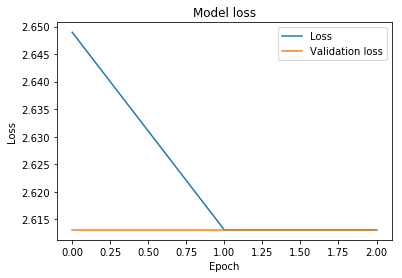

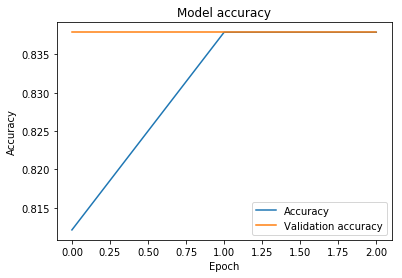

In [7]:
'''
Plot loss and accuracy
'''
plt.plot(loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(["Loss","Validation loss"])
plt.show()

plt.plot(acc)
plt.plot(val_acc)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(["Accuracy","Validation accuracy"])
plt.show()